# Project: Testing the Platonic Representation Hypothesis
**Student:** Elena Daveri
**Course:** Computer Vision and Intelligent Media Recognition

## 1. Objective
This experiment investigates the limits of the **Platonic Representation Hypothesis** in a multimodal context.
We aim to quantify whether neural networks trained on radically different input topologies (**1D signals** vs **2D images**) converge to a shared internal geometry.

**Research Question:** Does the learned geometric structure depend more on the *architecture/modality* or on the *semantic concepts* (classes)?

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  

# Datasets and DataLoaders
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Setup completed.")
print(f"Device in use: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Setup completed.
Device in use: cuda
GPU: NVIDIA GeForce GTX 1660


## Mathematical Framework: Linear CKA
We use **Centered Kernel Alignment (CKA)** with a linear kernel to measure similarity invariant to orthogonal rotation and isotropic scaling.

$$CKA(K, L) = \frac{HSIC(K, L)}{\sqrt{HSIC(K, K) \cdot HSIC(L, L)}}$$

Where $K = XX^T$ and $L = YY^T$ are the Gram matrices of the representations.

In [8]:
def centering_matrix(n, device):
    """Centering matrix H = I - (1/n) * 11^T    
    Args:
        n (int): Numero di campioni
        device: Dispositivo su cui creare la matrice (CPU o GPU)
    Returns:
        torch.Tensor: Centering Matrix(n, n)
    """
    H = torch.eye(n, device=device) - torch.ones((n, n), device=device) / n
    return H

def linear_hsic(X, Y, device):
    """Compute Hilbert-Schmidt Independence Criterion (Linear Kernel)
    Args:
        X (torch.Tensor): Feature matrix X (n_samples, n_features_X)
        Y (torch.Tensor): Feature matrix Y (n_samples, n_features_Y)
        device: Used device(CPU o GPU)"""
    n = X.shape[0]
    K = torch.matmul(X, X.T) # Gram Matrix X
    L = torch.matmul(Y, Y.T) # Gram Matrix Y
    H = centering_matrix(n, device)
    
    # Trace(KHLH) / (n-1)^2
    KH = torch.matmul(K, H)
    LH = torch.matmul(L, H)
    return torch.trace(torch.matmul(KH, LH)) / ((n - 1) ** 2)

def linear_cka(X, Y):
    """
    Compute Centered Kernel Alignment (CKA) using linear kernels.
    X, Y must have the same number of samples.
    Args:
        X (torch.Tensor): Feature matrix X (n_samples, n_features_X)
        Y (torch.Tensor): Feature matrix Y (n_samples, n_features_Y)
    Returns:
        float: CKA similarity score between X and Y
    """
    assert X.shape[0] == Y.shape[0], f"Error dimensions: {X.shape[0]} vs {Y.shape[0]}"
    
    hsic_xy = linear_hsic(X, Y, X.device)
    hsic_xx = linear_hsic(X, X, X.device)
    hsic_yy = linear_hsic(Y, Y, Y.device)
    
    return hsic_xy / (torch.sqrt(hsic_xx) * torch.sqrt(hsic_yy))

## Methodology: Class-Conditional Alignment
To compute a valid CKA score between disjoint datasets (MNIST-1D and MNIST-2D), we cannot simply compare random batches. The rows of the feature matrices $X$ and $Y$ must correspond to the same underlying concepts.

**Protocol:**
1. We extract features from both models.
2. We **sort and balance** the samples by class label (0 $\to$ 9).
3. This ensures row-wise semantic correspondence: $X_i$ and $Y_i$ represent the same digit class, allowing CKA to measure the structural alignment of the concept space.

In [9]:
def get_balanced_features(model, data_loader, device, num_samples_per_class=50):
    """
    Extract balanced features from the model for a given data_loader.
    Args:
    - model: PyTorch model (assumed to return features in forward pass)
    - data_loader: DataLoader for the dataset (should yield (inputs, labels))
    - device: Device to perform computations (CPU or GPU)
    - num_samples_per_class: Number of samples to select per class (default=50)
    Returns:
    - Tensor of shape (num_classes * num_samples_per_class, feature_dim) with balanced features
    """
    model.eval()
    
    # 1. Collect all features and labels
    all_feats = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            if not isinstance(x, torch.Tensor): 
                x = torch.tensor(x).float().to(device)
            
            # Forward pass 
            _, feats = model(x)
            all_feats.append(feats)
            all_labels.append(y)
            
    cat_feats = torch.cat(all_feats, dim=0)
    cat_labels = torch.cat(all_labels, dim=0).cpu() # CPU for indexing
    
    # 2. Select balanced samples per class
    balanced_feats = []
    for class_idx in range(10):
        # Find indexes where label == class_idx
        indices = (cat_labels == class_idx).nonzero(as_tuple=True)[0]
        
        if len(indices) < num_samples_per_class:
            raise ValueError(f"Class {class_idx} has only {len(indices)} samples, but {num_samples_per_class} are required")
            
        selected_indices = indices[:num_samples_per_class]
        balanced_feats.append(cat_feats[selected_indices])
        
    # 3. Concat balanced features
    return torch.cat(balanced_feats, dim=0)

## Model Architectures & Experimental Setup
To rigorously test the hypothesis, we design two distinct architectures that share a common latent dimensionality but differ in inductive bias:

1.  **Mnist1DNet (MLP):** A fully connected network processing 1D sequential signals. It relies on global receptive fields.
2.  **Mnist2DNet (CNN):** A convolutional network processing 2D spatial grids. It relies on local inductive biases (translation invariance).

**Crucial Design Choice:** Both models project data into a **shared 128-dimensional latent bottleneck** before the final classification head. This 128-dim space is where we perform the CKA alignment analysis.

In [ ]:
# Model and Training MNIST-1D
class Mnist1DNet(nn.Module):
    def __init__(self, input_size=40):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        h = self.features(x)
        out = self.classifier(h)
        return out, h

def train_mnist1d(seed, args):
    # set seed for reproducibility/variability
    set_seed(seed)
    
    # 1. Load dataset
    data = get_dataset(args, path='./mnist1d_data.pkl', download=True, regenerate=False)
    
    # 2. Prepare tensors
    x_train = torch.Tensor(data['x']).float().to(device)
    y_train = torch.LongTensor(data['y']).to(device)
    x_test = torch.Tensor(data['x_test']).float().to(device)
    y_test = torch.LongTensor(data['y_test'])
    
    # Read input dimension directly from loaded data
    # x_train.shape is (N_samples, Input_dim), so we take index 1
    real_input_dim = x_train.shape[1] 
    # ------------------------

    # 3. Setup Training
    test_ds = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model = Mnist1DNet(input_size=real_input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # 4. Training Loop
    model.train()
    for _ in range(50):
        optimizer.zero_grad()
        logits, _ = model(x_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()
        
    return model, test_loader

In [ ]:
# Model and Training MNIST-2D
class Mnist2DNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*7*7, 128), nn.ReLU() # Project to 128-dim features
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        h = self.features(x)
        out = self.classifier(h)
        return out, h

def train_mnist2d(seed):
    # set seed for reproducibility/variability
    set_seed(seed)
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
    
    model = Mnist2DNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    epochs = 3
    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Seed {seed})")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item()})
            
    return model, test_loader

### Independent Training Protocol
We train **5 independent instances** of each model architecture using different random seeds.
* **Total Models:** 10 (5 x 1D, 5 x 2D)
* **Optimization:** Adam optimizer, CrossEntropy loss.
* **Goal:** By comparing different initializations, we can distinguish between *chance alignment* and *true representation convergence*.

Training 5 MNIST-1D models...
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Model 1D #1 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Model 1D #2 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Model 1D #3 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Model 1D #4 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Model 1D #5 trained.

 Training 5 MNIST-2D models...


Epoch 1/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #1 trained.


Epoch 1/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #2 trained.


Epoch 1/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #3 trained.


Epoch 1/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #4 trained.


Epoch 1/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #5 trained.

 Computing CKA Matrices...

 FINAL RESULTS
1. 1D Convergence (Self-CKA): 0.9639
   How similar are the 1D models to each other?
2. 2D Convergence (Self-CKA): 0.9461
   How similar are the 2D models to each other?
3. Platonic Score (1D vs 2D): 0.2422
   (Average similarity between 1D and 2D representations)


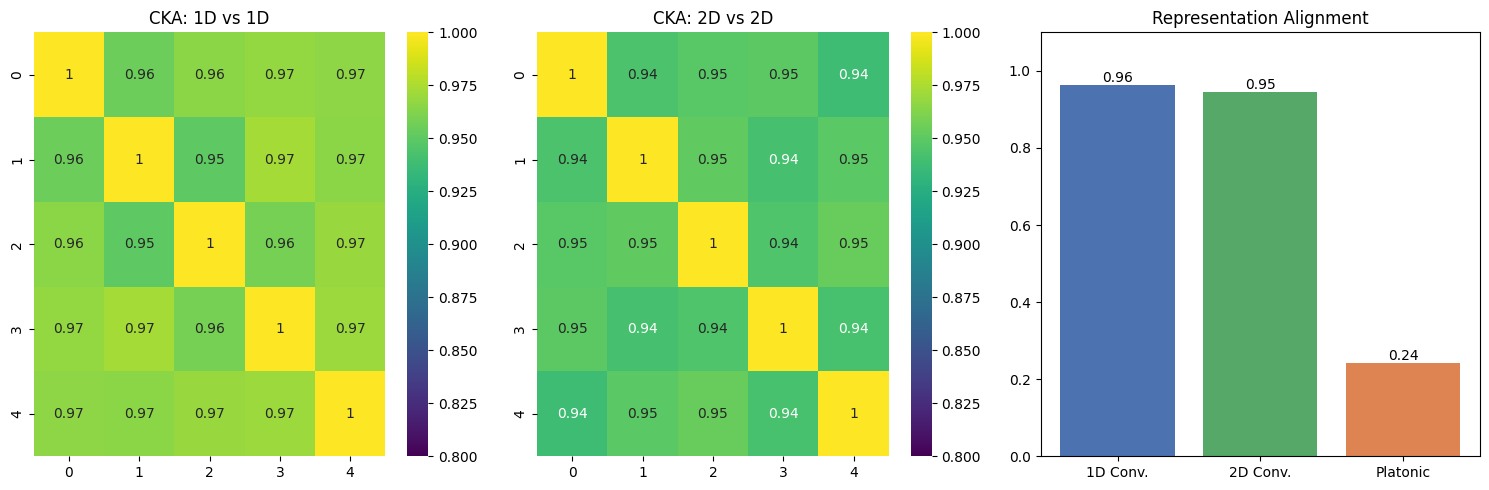

In [12]:
# --- EXPERIMENT SETUP ---
NUM_MODELS = 5
SAMPLES_PER_CLASS = 80 

# 1. Train 5 1D Models 
print(f"Training {NUM_MODELS} MNIST-1D models...")
args_1d = get_dataset_args()
feats_1d_list = []
for i in range(NUM_MODELS):
    seed = 42 + i
    m, l = train_mnist1d(seed, args_1d)
    feats_1d_list.append(get_balanced_features(m, l, device, SAMPLES_PER_CLASS))
    print(f"Model 1D #{i+1} trained.")

# 2. Train 5 2D Models
print(f"\n Training {NUM_MODELS} MNIST-2D models...")
feats_2d_list = []
for i in range(NUM_MODELS):
    seed = 100 + i # Different seeds from 1D models
    m, l = train_mnist2d(seed)
    feats_2d_list.append(get_balanced_features(m, l, device, SAMPLES_PER_CLASS))
    print(f"   Model 2D #{i+1} trained.")

# 3. Compute CKA
print("\n Computing CKA Matrices...")

def compute_cka_matrix(list_a, list_b):
    size_a, size_b = len(list_a), len(list_b)
    matrix = torch.zeros((size_a, size_b))
    for i in range(size_a):
        for j in range(size_b):
            matrix[i, j] = linear_cka(list_a[i], list_b[j])
    return matrix

cka_1d_1d = compute_cka_matrix(feats_1d_list, feats_1d_list)
cka_2d_2d = compute_cka_matrix(feats_2d_list, feats_2d_list)
cka_cross = compute_cka_matrix(feats_1d_list, feats_2d_list)

# Compute means for final scores
# For self-CKA we exclude the diagonal (which is always 1.0)
mask = torch.eye(NUM_MODELS) == 0
mean_self_cka_1d = cka_1d_1d[mask].mean().item()
mean_self_cka_2d = cka_2d_2d[mask].mean().item()
# For the Platonic Score we use the mean of all cross comparisons (25 pairs)
mean_platonic_score = cka_cross.mean().item()

# --- RESULTS ---
print("\n" + "="*30)
print(f" FINAL RESULTS")
print("="*30)
print(f"1. 1D Convergence (Self-CKA): {mean_self_cka_1d:.4f}")
print(f"   How similar are the 1D models to each other?")
print(f"2. 2D Convergence (Self-CKA): {mean_self_cka_2d:.4f}")
print(f"   How similar are the 2D models to each other?")
print(f"3. Platonic Score (1D vs 2D): {mean_platonic_score:.4f}")
print(f"   (Average similarity between 1D and 2D representations)")
# --- VISUALIZATION ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cka_1d_1d.cpu().numpy(), annot=True, cmap='viridis', vmin=0.8)
plt.title("CKA: 1D vs 1D")

plt.subplot(1, 3, 2)
sns.heatmap(cka_2d_2d.cpu().numpy(), annot=True, cmap='viridis', vmin=0.8)
plt.title("CKA: 2D vs 2D")

plt.subplot(1, 3, 3)
bars = plt.bar(["1D Conv.", "2D Conv.", "Platonic"], 
                [mean_self_cka_1d, mean_self_cka_2d, mean_platonic_score], 
                color=['#4c72b0', '#55a868', '#dd8452'])
plt.ylim(0, 1.1)
plt.title("Representation Alignment")
plt.bar_label(bars, fmt='%.2f')

plt.tight_layout()
plt.show()

## Discussion & Conclusions

### Interpretation of Results
* **Intra-Domain Convergence (> 0.94):** Models with the same architecture converge to nearly identical representational geometries.
* **Platonic Score (~ 0.24):** The cross-domain alignment is significantly above random but far from perfect isomorphism.

### Critical Analysis
The score of **0.24** reveals a **Partial Convergence**.
While the models successfully extract a **Shared Semantic Structure** (clustering of classes 0-9), the local geometry remains heavily influenced by the **Inductive Bias** of the modality (Sequence vs. Spatial Grid).
The "Platonic Reality" is emerging, but it is still distorted by the sensory "shadows" (1D vs 2D inputs).